In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

In [ ]:
## load csv files in folder
# folder = os.path.abspath('./good_metrics/No_window')
# folder = os.path.abspath('./good_metrics/windowed_no_hilbert')
folder = os.path.abspath('./good_metrics/with_hilbert')

files = [f for f in os.listdir(folder) if f.endswith('.csv')]

df_list = []
for f in files:
    splitted_filename = f.split('_')
    if '-' in splitted_filename[1]:
        model_name = splitted_filename[0]
    else:
        model_name = splitted_filename[0] + '_' + splitted_filename[1]

    temp_df = pd.read_csv(os.path.join(folder, f))
    temp_df['Model'] = model_name
    df_list.append(temp_df)
df = pd.concat(df_list, ignore_index=True)

for metric in df.columns:
    if '(ms)' in metric:
        base_metric = metric.replace(' (ms)', '')
        if base_metric in df.columns:
            # Only update non-NaN values from the (ms) column
            df[base_metric] = df[base_metric].combine_first(df[metric])
        else:
            # If base column doesn't exist, just rename it
            df.rename(columns={metric: base_metric}, inplace=True)

print(np.unique(df['Model']))
print(df.columns.tolist())

['CNN' 'GRU' 'GRU_Attention' 'GRU_Conv' 'LSN' 'LSTM' 'MLP' 'Parametric'
 'STGCN' 'TTR']
['Event', 'TP', 'FP', 'FN', 'Precision', 'Recall', 'F1', 'MATE', 'median ATE', 'MATE_std', 'minmax ATE', 'MTE', 'median TE', 'MTE_std', 'minmax TE', 'Model', 'MATE (ms)', 'median ATE (ms)', 'MATE_std (ms)', 'minmax ATE (ms)', 'MTE (ms)', 'median TE (ms)', 'MTE_std (ms)', 'minmax TE (ms)']


In [54]:
## What to plot and how
metrics = ['Precision', 'Recall', 'F1']
ms_metrics = ['MATE', 'median ATE', 'MATE_std']
events = df['Event'].unique()
# model_order = ['TTR', 'STGCN', 'LSTM', 'LSN', 'GRU', 'GRU_Attention', 'GRU_Conv', 'CNN', 'MLP', 'Parametric']
# model_order = ['STTR', 'STTR_Acute']#, 'Parametric']
model_order = np.unique(df['Model'])
model_order = ['MLP', 'CNN', 'GRU', 'GRU_Attention', 'GRU_Conv', 'LSTM', 'LSN', 'STTR', 'STGCN']

Model
CNN              4
GRU              4
GRU_Attention    4
GRU_Conv         4
LSN              4
LSTM             4
MLP              4
Parametric       4
STGCN            4
TTR              4
dtype: int64
Precision     1
Recall        1
F1            1
MATE          1
median ATE    1
MATE_std      1
dtype: int64
       Precision    Recall        F1
count   8.000000  8.000000  8.000000
mean    0.010103  0.006564  0.007728
std     0.009451  0.004099  0.005635
min     0.002688  0.002544  0.002586
25%     0.005185  0.004172  0.004600
50%     0.006600  0.005262  0.005741
75%     0.010217  0.007568  0.008635
max     0.031845  0.014780  0.019751
               Precision     Recall         F1
Model                                         
MLP            86.559139  47.822580  59.082181
CNN            82.526881  41.169355  52.235022
GRU            94.758064  66.854839  76.507936
GRU_Attention  99.462365  80.967742  87.869943
GRU_Conv       98.897849  79.045699  86.190475
LSTM           98.65

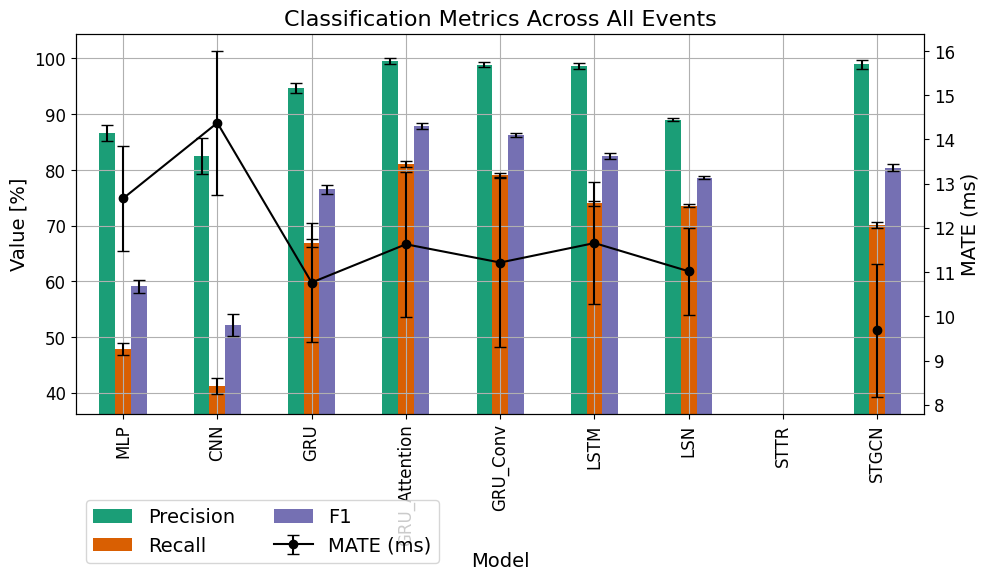

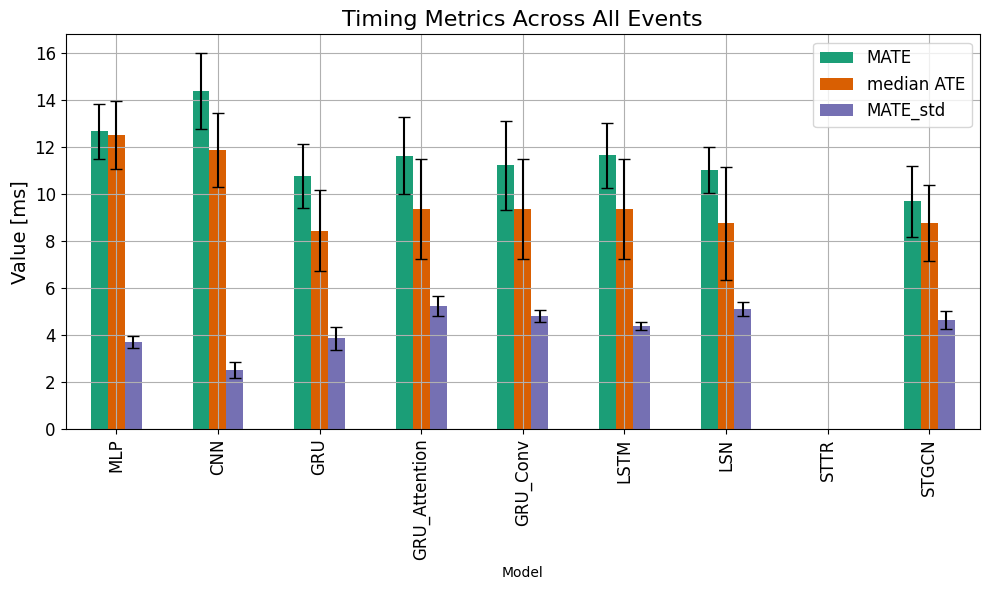

In [55]:
# Group and reorder
model_stats = df.groupby('Model')[metrics + ms_metrics]
model_means = model_stats.mean().reindex(model_order)
model_sem = model_stats.sem().reindex(model_order)

print(df.groupby('Model').size())           # Check group counts
print(model_sem.isna().sum())               # Check for SEM NaNs
print(model_sem[metrics].describe())

## Color map
cmap = plt.get_cmap('Dark2')
num_models = len(model_means) +  1
bar_colors = [cmap(i) for i in range(num_models)]

## Plotting metrics
fig, ax1 = plt.subplots(figsize=(10, 6))
model_means[metrics] = model_means[metrics] * 1e2 # Convert to percentage
model_sem[metrics] = model_sem[metrics] * 1e2 # Convert to percentage
model_means[metrics].plot(kind='bar', yerr=model_sem[metrics], capsize=4, ax=ax1, color=bar_colors)

# Add MATE (ms) as a line plot with SEM as error bars using a secondary y-axis
ax3 = ax1.twinx()
ax3.errorbar(
    model_means.index,
    model_means['MATE'],
    yerr=model_sem['MATE'],
    color='black',
    marker='o',
    label='MATE (ms)',
    linewidth=1.5,
    markersize=6,
    capsize=4
)
ax3.set_ylabel('MATE (ms)', fontsize=14, color='black')
ax3.tick_params(axis='y', labelsize=12, colors='black')
# ax3.set_ylim(0, max(model_means['MATE'] + model_sem['MATE']) * 1.1)

ax1.set_title('Classification Metrics Across All Events', fontsize=16)
ax1.set_ylabel('Value [%]', fontsize=14)
print(model_means[metrics])
ax1.set_ylim(min(model_means[metrics].min(skipna=True)) - 0.05 * max(model_means[metrics].max(skipna=True)), max(model_means[metrics].max(skipna=True)) + 0.05 * max(model_means[metrics].max(skipna=True)))
ax1.set_xlabel('Model', fontsize=14)
ax1.tick_params(axis='x', labelsize=12)
ax1.tick_params(axis='y', labelsize=12)
ax1.grid(True)
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax3.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2, loc='upper left', bbox_to_anchor=(0, -0.2), ncol=2, fontsize=14)
plt.tight_layout()
plt.show()

# Plotting timing metrics
fig, ax2 = plt.subplots(figsize=(10, 6))
model_means[ms_metrics].plot(kind='bar', yerr=model_sem[ms_metrics], capsize=4, ax=ax2, color=bar_colors)

ax2.set_title('Timing Metrics Across All Events', fontsize=16)
ax2.set_ylabel('Value [ms]', fontsize=14)
ax2.tick_params(axis='x', labelsize=12)
ax2.tick_params(axis='y', labelsize=12)
ax2.legend(fontsize=12)
ax2.grid(True)
plt.tight_layout()
plt.show()

# Save both figures as SVG
fig = ax1.get_figure()
fig.savefig("model_metrics_all.svg", format="svg")


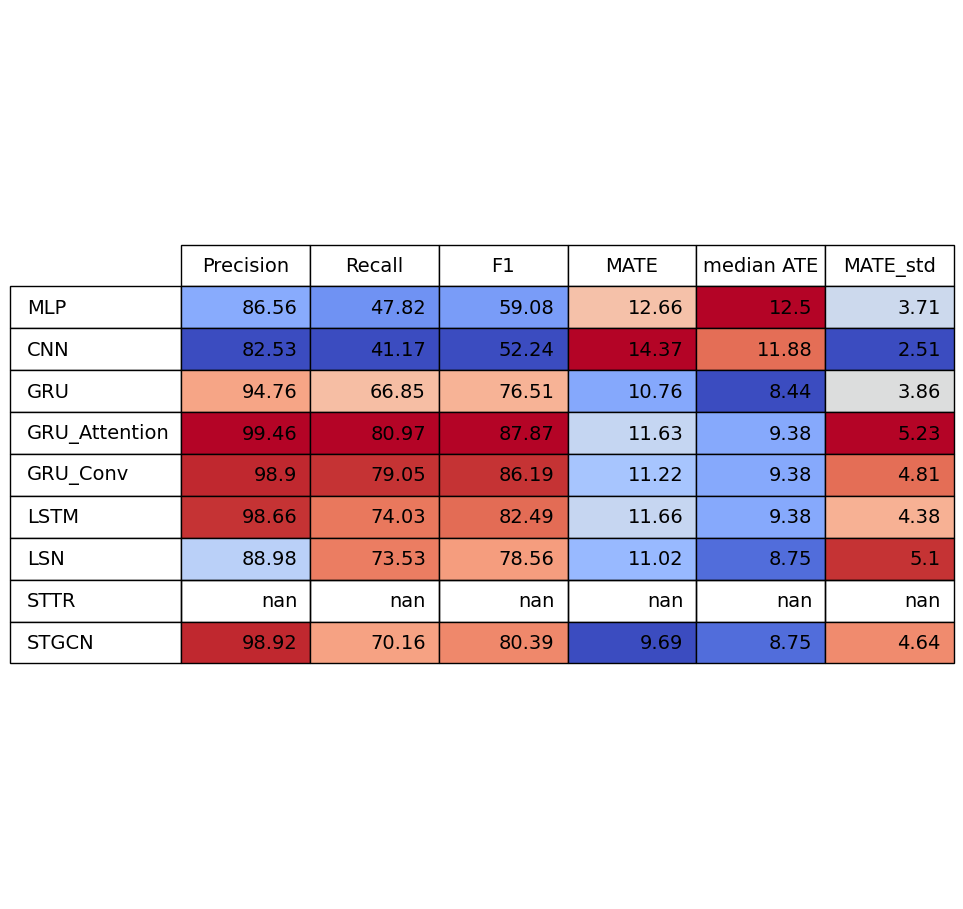

In [56]:
## Display the DataFrame with the calculated means
model_means_display = model_means.copy()
model_means_display[metrics] = model_means_display[metrics].round(2)
model_means_display[ms_metrics] = model_means_display[ms_metrics].round(2)
model_means_display

# Reorder model_means_display to follow model_order
model_means_display = model_means_display.reindex(model_order)

fig_table, ax_table = plt.subplots(figsize=(10, 2 + 0.8 * len(model_means_display)))  # Increase row height

# Normalize each column for color mapping
normed = (model_means_display - model_means_display.min()) / (model_means_display.max() - model_means_display.min())
colors = plt.cm.coolwarm(normed.values)

# Create the table
table = ax_table.table(
    cellText=model_means_display.values,
    rowLabels=model_means_display.index,
    colLabels=model_means_display.columns,
    cellColours=colors,
    loc='center'
)
table.auto_set_font_size(False)
table.set_fontsize(14)
table.scale(1.2, 2.0)  # Increase row height
ax_table.axis('off')
plt.title("", fontsize=14)
plt.tight_layout()
plt.show()
fig_table.savefig("./figures/Model/model_metrics_table.svg", format="svg")
